<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fourmethod/notebooks/SmoothNF_Vs_AffineNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit coupling layers


In [ ]:
!pip install --quiet numpyro dm-haiku==0.0.5 optax
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git

     |████████████████████████████████| 283 kB 12.4 MB/s 
     |████████████████████████████████| 287 kB 35.3 MB/s 
     |████████████████████████████████| 140 kB 26.7 MB/s 
     |████████████████████████████████| 72 kB 605 kB/s 
  Cloning https://github.com/Justinezgh/SBI-Diff-Simulator.git to /tmp/pip-req-build-ccda_sxr
  Running command git clone -q https://github.com/Justinezgh/SBI-Diff-Simulator.git /tmp/pip-req-build-ccda_sxr
     |████████████████████████████████| 112 kB 7.5 MB/s 
  Created wheel for SBI-Diff-Simulator: filename=SBI_Diff_Simulator-0.0.1-py3-none-any.whl size=6971 sha256=58332a84ce133ce782e91d41c0c72ca8382dd18f7a3628ba9b92a5413ce602ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-gp0640b2/wheels/23/08/59/9849057a0895ebcf36bac0f7c31ebe48c9a86a2d0f19bd93e7
Successfully built SBI-Diff-Simulator


In [ ]:
%pylab inline
import jax
import jax.numpy as jnp
import haiku as hk
import optax
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


### Affine coupling layer VS smooth coupling layer (trained with score matching)

In [ ]:
d=2
batch_size = 1024

In [ ]:
from sbiexpt.distributions import get_two_moons
#from sbiexpt.bijectors import MixtureAffineSigmoidBijector 
from sbids.bijectors.bijectors import MixtureAffineSigmoidBijector

In [ ]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma = 0.01, normalized=True)
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)
  return batch, score

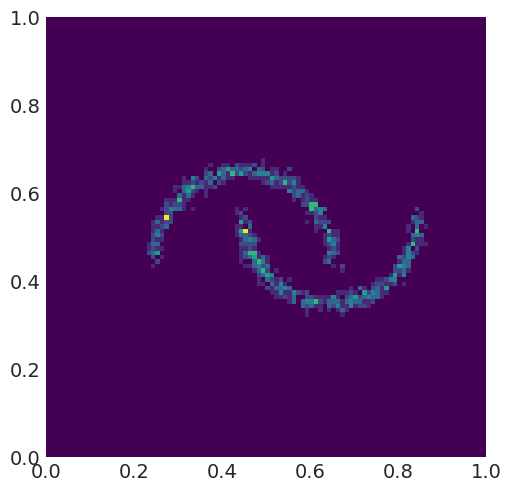

In [ ]:
import arviz as az
az.style.use("arviz-darkgrid")
batch, score = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]); gca().set_aspect('equal');

#### Affine

In [ ]:
class AffineCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):
    net = hk.Linear(256)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(256)(net)
    net = jax.nn.leaky_relu(net)
    shifter = tfb.Shift(hk.Linear(output_units)(net))
    scaler = tfb.Scale(jnp.clip(jnp.exp(hk.Linear(output_units)(net)), 1e-2, 1e2))
    return tfb.Chain([shifter, scaler])    

In [ ]:
class AffineFlow(hk.Module):
    """This is a normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
        chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(name='aff1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling(name='aff2')),
            tfb.Permute([1,0]),
        ])
        
        nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(jnp.zeros(d),jnp.ones(d)),
            bijector=chain)
        
        return nvp

In [ ]:
model_affine = hk.without_apply_rng(hk.transform(lambda x : AffineFlow()().log_prob(x)))

In [ ]:
rng_seq = hk.PRNGSequence(12)
params_affine = model_affine.init(next(rng_seq), jnp.zeros([1,d]))

In [ ]:
def loss_fn(params, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x, p: model_affine.apply(p, x.reshape([1,2])).squeeze()), [0, None])(batch, params) 
  return  jnp.mean( jnp.sum((out - score)**2, axis=1))/1000  

In [ ]:
@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [ ]:
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state = optimizer.init(params_affine)

In [ ]:
losses = []
master_seed = hk.PRNGSequence(0)

In [ ]:
for step in tqdm(range(10000)):
    batch, score = get_batch(next(master_seed))
    l, params_affine, opt_state = update(params_affine, opt_state, batch, score)
    losses.append(l)

100%|██████████| 10000/10000 [03:26<00:00, 48.43it/s]


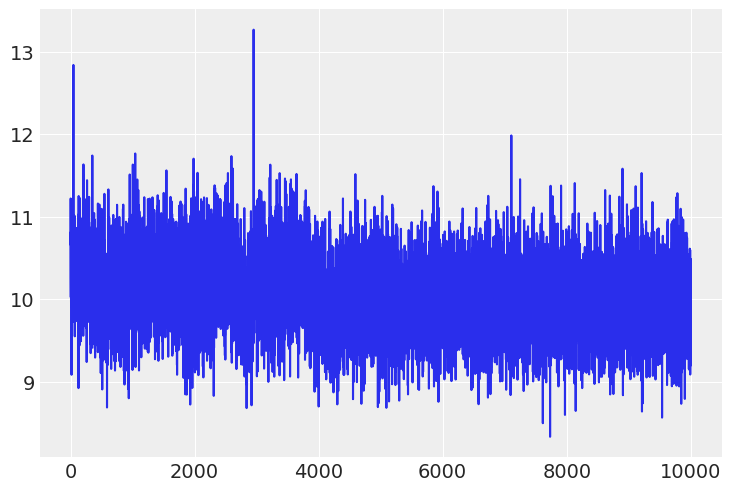

In [ ]:
plt.plot(losses)

Text(0.5, 1.0, 'NF with affine coupling layers trained with score')

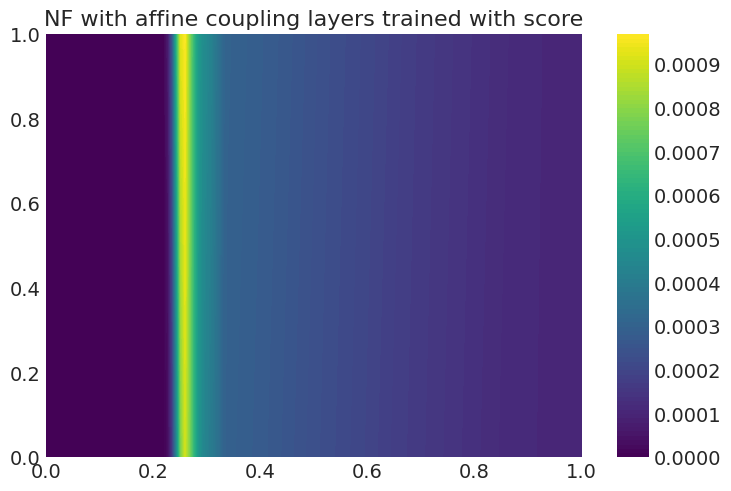

In [ ]:
# predicted two moons distribution
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

im0 = jax.vmap((lambda x: model_affine.apply(params_affine, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im0), 100); colorbar()
plt.title('NF with affine coupling layers trained with score')

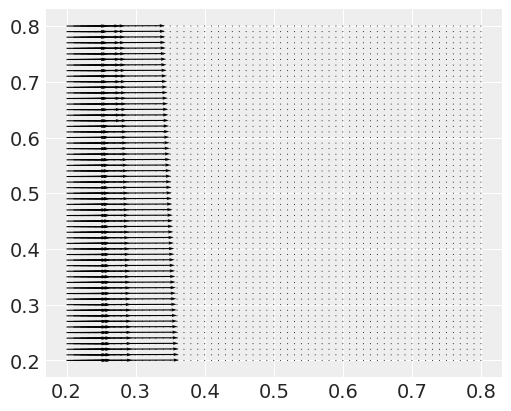

In [ ]:
# score field
plt.figure(figsize=(5,4))
X = np.arange(0.2, 0.8, 0.01)
Y = np.arange(0.2, 0.8, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
pred_score = jax.vmap(jax.grad(lambda x: model_affine.apply(params_affine, x).squeeze()))(points).reshape([len(Y), len(X),2])
quiver(X, Y, pred_score[:,:,0] ,pred_score[:,:,1]);

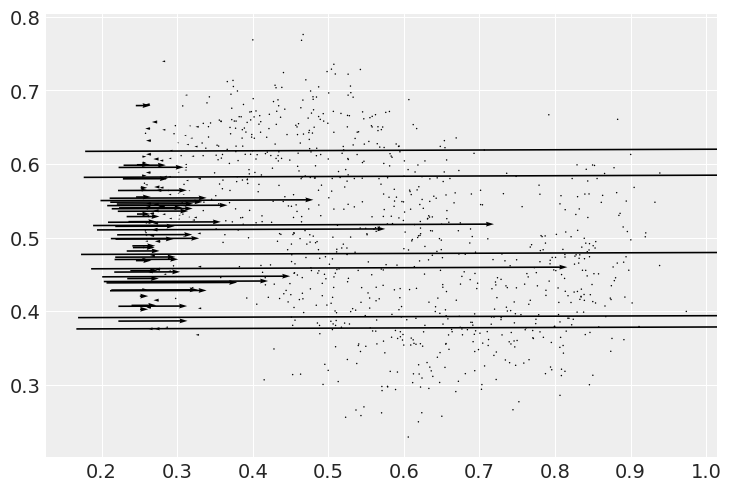

In [ ]:
# score only on the two moons distribution
two_moons = get_two_moons(sigma = 0.05, normalized=True)
batch=two_moons.sample(1000, seed=next(master_seed))
pred_score = jax.vmap(jax.grad(lambda x: model_affine.apply(params_affine, x).squeeze()))(batch)
quiver(batch.T[0], batch.T[1], pred_score[:,0] ,pred_score[:,1]);
#plt.savefig('scorenfnul.png')

#### Smooth

In [ ]:
class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):

    # NN to get a b and c
    net = hk.Linear(256, name='l1')(x)
    net = jax.nn.silu(net)
    net = hk.Linear(256, name='l2')(net)
    net = jax.nn.silu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 16
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p = jax.nn.softmax(hk.Linear(n_components, name='l6')(net))

    log_a = log_a.reshape(-1,output_units,n_components)
    b = b.reshape(-1,output_units,n_components)
    c = c.reshape(-1,output_units,n_components)
    p = p.reshape(-1,output_units,n_components)
    p = jax.nn.softmax(p)

    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c, p)

class SmoothFlow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b2')),
            tfb.Permute([1,0]),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.Independent(tfd.TruncatedNormal(0.5*jnp.ones(d), 
                                                0.1*jnp.ones(d), 
                                                0.01,0.99),
                            reinterpreted_batch_ndims=1),
            bijector=chain)
        
      return nvp

In [ ]:
model_smooth = hk.without_apply_rng(hk.transform(lambda x : SmoothFlow()().log_prob(x)))

In [ ]:
rng_seq = hk.PRNGSequence(0)
params_smooth = model_smooth.init(next(rng_seq), jnp.zeros([1,d]))

In [ ]:
# This is the loss for score matching
def loss_fn_smooth(params, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x, p: model_smooth.apply(p, x.reshape([1,2])).squeeze()), [0, None])(batch, params) 
  return  jnp.mean( jnp.sum((out - score)**2, axis=1))/1000 

In [ ]:
@jax.jit
def update_smooth(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn_smooth)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [ ]:
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state = optimizer.init(params_smooth)

In [ ]:
losses = []
master_seed = hk.PRNGSequence(0)

In [ ]:
for step in tqdm(range(10000)):
    batch, score = get_batch(next(master_seed))
    l, params_smooth, opt_state = update_smooth(params_smooth, opt_state, batch, score)
    losses.append(l)

100%|██████████| 10000/10000 [08:17<00:00, 20.11it/s]


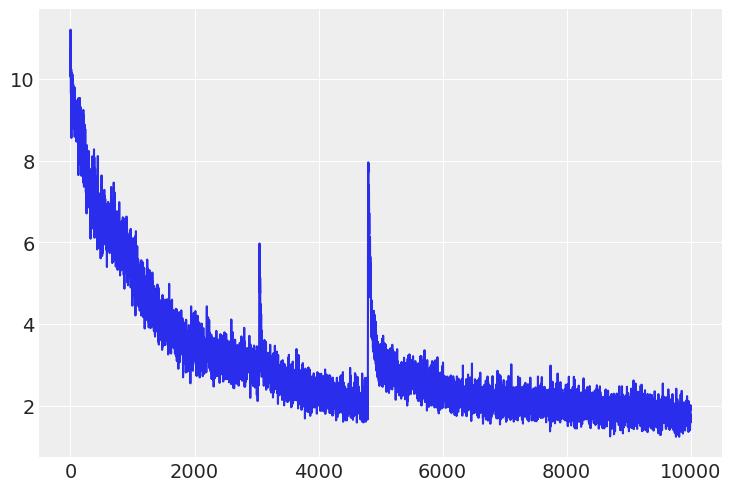

In [ ]:
plot(losses)

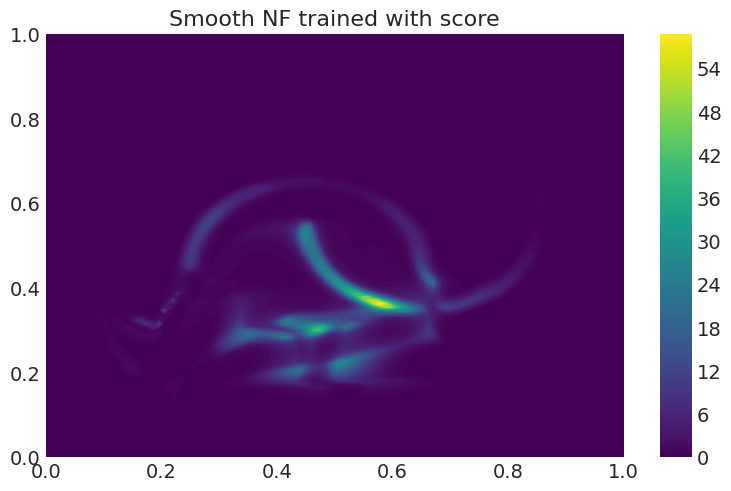

In [ ]:
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

im0 = jax.vmap((lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im0), 100); colorbar()
plt.title('Smooth NF trained with score')
plt.savefig("smoothnf.png")
jnp.save('nfcool.npy', im0)

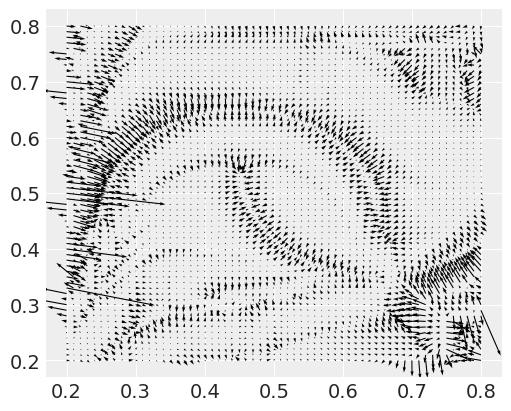

In [ ]:
plt.figure(figsize=(5,4))
X = np.arange(0.2, 0.8, 0.01)
Y = np.arange(0.2, 0.8, 0.01)
pred_score = jax.vmap(jax.grad(lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(points).reshape([len(Y), len(X),2])
quiver(X, Y, pred_score[:,:,0] ,pred_score[:,:,1]);


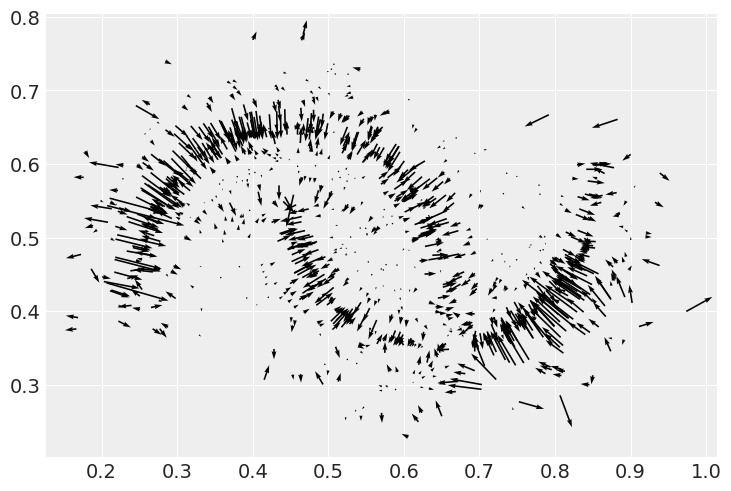

In [ ]:
two_moons = get_two_moons(sigma = 0.05, normalized=True)
batch=two_moons.sample(1000, seed=next(master_seed))
pred_score = jax.vmap(jax.grad(lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(batch)
quiver(batch.T[0], batch.T[1], pred_score[:,0] ,pred_score[:,1]);